# Prerequisites

In [2]:
%matplotlib inline
%run fcast.py

# customize matplotlib plots
mpl.style.use('seaborn-darkgrid')
plt.rc('font', family='TH Sarabun New')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=16)
plt.rc('figure', figsize=(6.5,4), dpi=300)

# Prepare Data

In [3]:
hml = read_price('hml')
hml.meta = SimpleNamespace()
hml.meta.abb = 'hml'
hml.meta.shortname = 'ข้าวหอมมะลิ'
hml.meta.fullname = 'ราคาข้าวเปลือกหอมมะลิ ที่เกษตรกรขายได้ ณ ไร่นา'

wht = read_price('wht')
wht.meta = SimpleNamespace()
wht.meta.abb = 'wht'
wht.meta.shortname = 'ข้าวเจ้าขาว'
wht.meta.fullname = 'ราคาข้าวเปลือกเจ้าขาว ที่เกษตรกรขายได้ ณ ไร่นา'

glu = read_price('glu')
glu.meta = SimpleNamespace()
glu.meta.abb = 'glu'
glu.meta.shortname = 'ข้าวเหนียว'
glu.meta.fullname = 'ราคาข้าวเปลือกเหนียวเมล็ดยาว ที่เกษตรกรขายได้ ณ ไร่นา'

prices = [hml, wht, glu]

In [12]:
n_diff = 1

for price in prices:
  price.scaled, price.scaler = data_transform(price, method='minmax')
  price.scaled_diff = price.scaled.diff(n_diff).dropna() if n_diff>0 else price.scaled
  price.n_diff = n_diff
  price.train, price.validate, price.train2, price.test = data_split(price.scaled_diff)
  print(price.meta.abb, price.train.size, price.validate.size, price.test.size)

hml 258 85 85
wht 258 85 85
glu 258 85 85


In [4]:
def data_2keras(data, n_lag=12, n_forecast=4, h=None):
  """
  Rearrange data into keras format also keep time index

  Args:
    data (dataframe or series): dataframe or series with time index
    n_lag (int): number of lags to be used in the model
    n_forecast (int): number of steps to forecast

  Returns:
    x (dataframe): input for training
    y (dataframe): output for training
    date_idx: date index
  """

  df = pd.DataFrame(index=data.index)

  for i in reversed(range(n_lag+1)):
      df[f'x{i}'] = data.shift(i)

  for i in range(1, n_forecast+1):
      df[f'y{i}'] = data.shift(-i)
  df = df.dropna()
  date_idx = df.index
  x = df.iloc[:, :n_lag+1]
  y = df.iloc[:, n_lag+1:] if h is None else df.iloc[:, n_lag+h]

  return x, y, date_idx

In [7]:
x, y, date_idx = data_2keras(hml, n_lag=12, n_forecast=4, h=4)
x

,x12,x11,x10,x9,x8,x7,x6,x5,x4,x3,x2,x1,x0
date,,,,,,,,,,,,,
1985-01-01,"3,024.8013","3,004.5982","2,979.4107","3,085.4853","3,106.0813","3,125.0000","3,665.1747","3,508.4962","3,346.4374","3,189.6063","3,027.5476","2,870.7165","2,905.3876"
1985-02-01,"3,004.5982","2,979.4107","3,085.4853","3,106.0813","3,125.0000","3,665.1747","3,508.4962","3,346.4374","3,189.6063","3,027.5476","2,870.7165","2,905.3876","2,864.2369"
1985-03-01,"2,979.4107","3,085.4853","3,106.0813","3,125.0000","3,665.1747","3,508.4962","3,346.4374","3,189.6063","3,027.5476","2,870.7165","2,905.3876","2,864.2369","2,970.5113"
1985-04-01,"3,085.4853","3,106.0813","3,125.0000","3,665.1747","3,508.4962","3,346.4374","3,189.6063","3,027.5476","2,870.7165","2,905.3876","2,864.2369","2,970.5113","2,929.9576"
1985-05-01,"3,106.0813","3,125.0000","3,665.1747","3,508.4962","3,346.4374","3,189.6063","3,027.5476","2,870.7165","2,905.3876","2,864.2369","2,970.5113","2,929.9576","2,910.0000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01,"13,359.0000","14,475.0000","15,106.0000","15,236.0000","15,539.0000","15,887.0000","15,991.0000","15,350.0000","15,138.0000","14,865.0000","15,280.0000","15,244.0000","15,145.0000"
2019-02-01,"14,475.0000","15,106.0000","15,236.0000","15,539.0000","15,887.0000","15,991.0000","15,350.0000","15,138.0000","14,865.0000","15,280.0000","15,244.0000","15,145.0000","15,590.0000"
2019-03-01,"15,106.0000","15,236.0000","15,539.0000","15,887.0000","15,991.0000","15,350.0000","15,138.0000","14,865.0000","15,280.0000","15,244.0000","15,145.0000","15,590.0000","15,721.0000"


# MLP

In [9]:
def mlp_fit(data, config, n_forecast=4, h=None):

  # unpack config
  n_lag, n_layers, n_nodes, n_epochs, n_batch, refit_rate = config
  
  # transform to keras format
  x, y, date_idx = data_2keras(data, n_lag=n_lag, n_forecast=n_forecast, h=h)
  x = x.to_numpy()
  y = y.to_numpy()
  n_input = x.shape[1]
  n_output = n_forecast if h is None else 1

  # define model
  model = Sequential()
  model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
  if n_layers==2:
    model.add(Dense(n_nodes, activation='relu'))
  elif n_layers==3:
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
  model.add(Dense(n_output))
  model.compile(loss='mse', optimizer='adam')
  
  # fit model
  model.fit(x, y, epochs=n_epochs, batch_size=n_batch, verbose=0)

  return model


def mlp_forecast(model_fitted, data, date, n_forecast=4, h=None):
  """
  Forecast MLP model

  Args:
      model_fitted (model): Keras fitted model
      data (dataframe): number of lags to be used in the model
      date (date): date when making the forecast
      n_forecast (int): number of steps to forecast

  Returns:

  """
  n_diff = getattr(data, "n_diff")
  scaler = getattr(data, "scaler")
  
  x_idx = data.scaled_diff.index.get_loc(date)
  x_idx = x_idx+1 if n_diff > 1 else x_idx
  x_t = data.scaled.iloc[x_idx].to_numpy()
  n_input  = model_fitted.input_shape[1]
  n_output = model_fitted.output_shape[1]

  # find-input
  x = data.scaled_diff.iloc[x_idx-n_input:x_idx,]
  x_input = x.to_numpy().reshape(1,-1)

  # forecast
  yhat = model_fitted.predict(x_input, verbose=0).reshape(-1,)
  yhat = x_t + yhat.cumsum() if n_diff == 1 else yhat # diff adjustment
  if h is None:
    yhat_idx = pd.date_range(date, periods=n_forecast+1, freq='MS')[1:]
  else:
    yhat_idx = [pd.date_range(date, periods=n_forecast+1, freq='MS')[h]]
  df = pd.DataFrame(yhat,
                    columns=["yhat_scaled"],
                    index=yhat_idx
                   )
  df['yhat'] = scaler.inverse_transform(df)
  return df['yhat'] 


def mlp_walk_forward(data, config, search_mode=False, n_forecast=4, method='joint'):

  train, test = select_traintest(data, search_mode)
  data_ = pd.concat([train,test])
  N = data_.shape[0]
  n_test = test.shape[0]
  n_yhat = n_test+1
  yhat = np.empty((n_yhat, n_forecast))
  refit_rate = config[-1]
  
  history = train
  if method == 'joint':
    model_fitted = mlp_fit(history, config, n_forecast=n_forecast)
    date = train.index[-1]
    for i in range(n_yhat):
      model_fitted = mlp_fit(history, config, n_forecast=n_forecast) if i%refit_rate==0 else model_fitted 
      yhat[i] = mlp_forecast(model_fitted, data, date, n_forecast=n_forecast)
      if i < n_yhat-1:
        history = history.append(test.iloc[i])
        date = test.index[i]
        
  elif method == 'seperated':
    model_fitted = [mlp_fit(history, config, n_forecast=n_forecast, h=h+1) for h in range(n_forecast)]
    date = train.index[-1]
    for i in range(n_yhat):
      model_fitted = [mlp_fit(history, config, n_forecast=n_forecast, h=h+1) for h in range(n_forecast)] if i%refit_rate==0 else model_fitted
      yhat_ = [mlp_forecast(model_fitted[h], data, date, n_forecast=4, h=h+1) for h in range(n_forecast)]
      yhat[i] = pd.concat(yhat_)
      K.clear_session()
      if i < n_yhat-1:
        history = history.append(test.iloc[i])
        date = test.index[i]
      
  yhat = pd.DataFrame(yhat,
                      columns=[f'yhat{h}' for h in range(1, n_forecast+1)],
                      index=data_.index[-n_test-1:])
  
  return yhat

In [579]:
res = mlp_walk_forward(hml, config, search_mode=False, n_forecast=4, method='seperated')

In [581]:
# res

In [496]:
n_lag = 11
n_layers = 2
n_nodes = 500
n_epochs = 20
n_batch = 128
refit_rate = np.inf
h = 2

config = (n_lag, n_layers, n_nodes, n_epochs, n_batch, refit_rate)

Train on 248 samples, validate on 75 samples
Epoch 1/20
 - 0s - loss: 0.0168 - val_loss: 0.0288
Epoch 2/20
 - 0s - loss: 0.0156 - val_loss: 0.0299
Epoch 3/20
 - 0s - loss: 0.0156 - val_loss: 0.0293
Epoch 4/20
 - 0s - loss: 0.0150 - val_loss: 0.0287
Epoch 5/20
 - 0s - loss: 0.0150 - val_loss: 0.0284
Epoch 6/20
 - 0s - loss: 0.0148 - val_loss: 0.0285
Epoch 7/20
 - 0s - loss: 0.0147 - val_loss: 0.0285
Epoch 8/20
 - 0s - loss: 0.0145 - val_loss: 0.0283
Epoch 9/20
 - 0s - loss: 0.0143 - val_loss: 0.0283
Epoch 10/20
 - 0s - loss: 0.0143 - val_loss: 0.0283
Epoch 11/20
 - 0s - loss: 0.0140 - val_loss: 0.0284
Epoch 12/20
 - 0s - loss: 0.0140 - val_loss: 0.0287
Epoch 13/20
 - 0s - loss: 0.0138 - val_loss: 0.0287
Epoch 14/20
 - 0s - loss: 0.0138 - val_loss: 0.0289
Epoch 15/20
 - 0s - loss: 0.0136 - val_loss: 0.0293
Epoch 16/20
 - 0s - loss: 0.0135 - val_loss: 0.0291
Epoch 17/20
 - 0s - loss: 0.0134 - val_loss: 0.0290
Epoch 18/20
 - 0s - loss: 0.0133 - val_loss: 0.0294
Epoch 19/20
 - 0s - loss: 0.

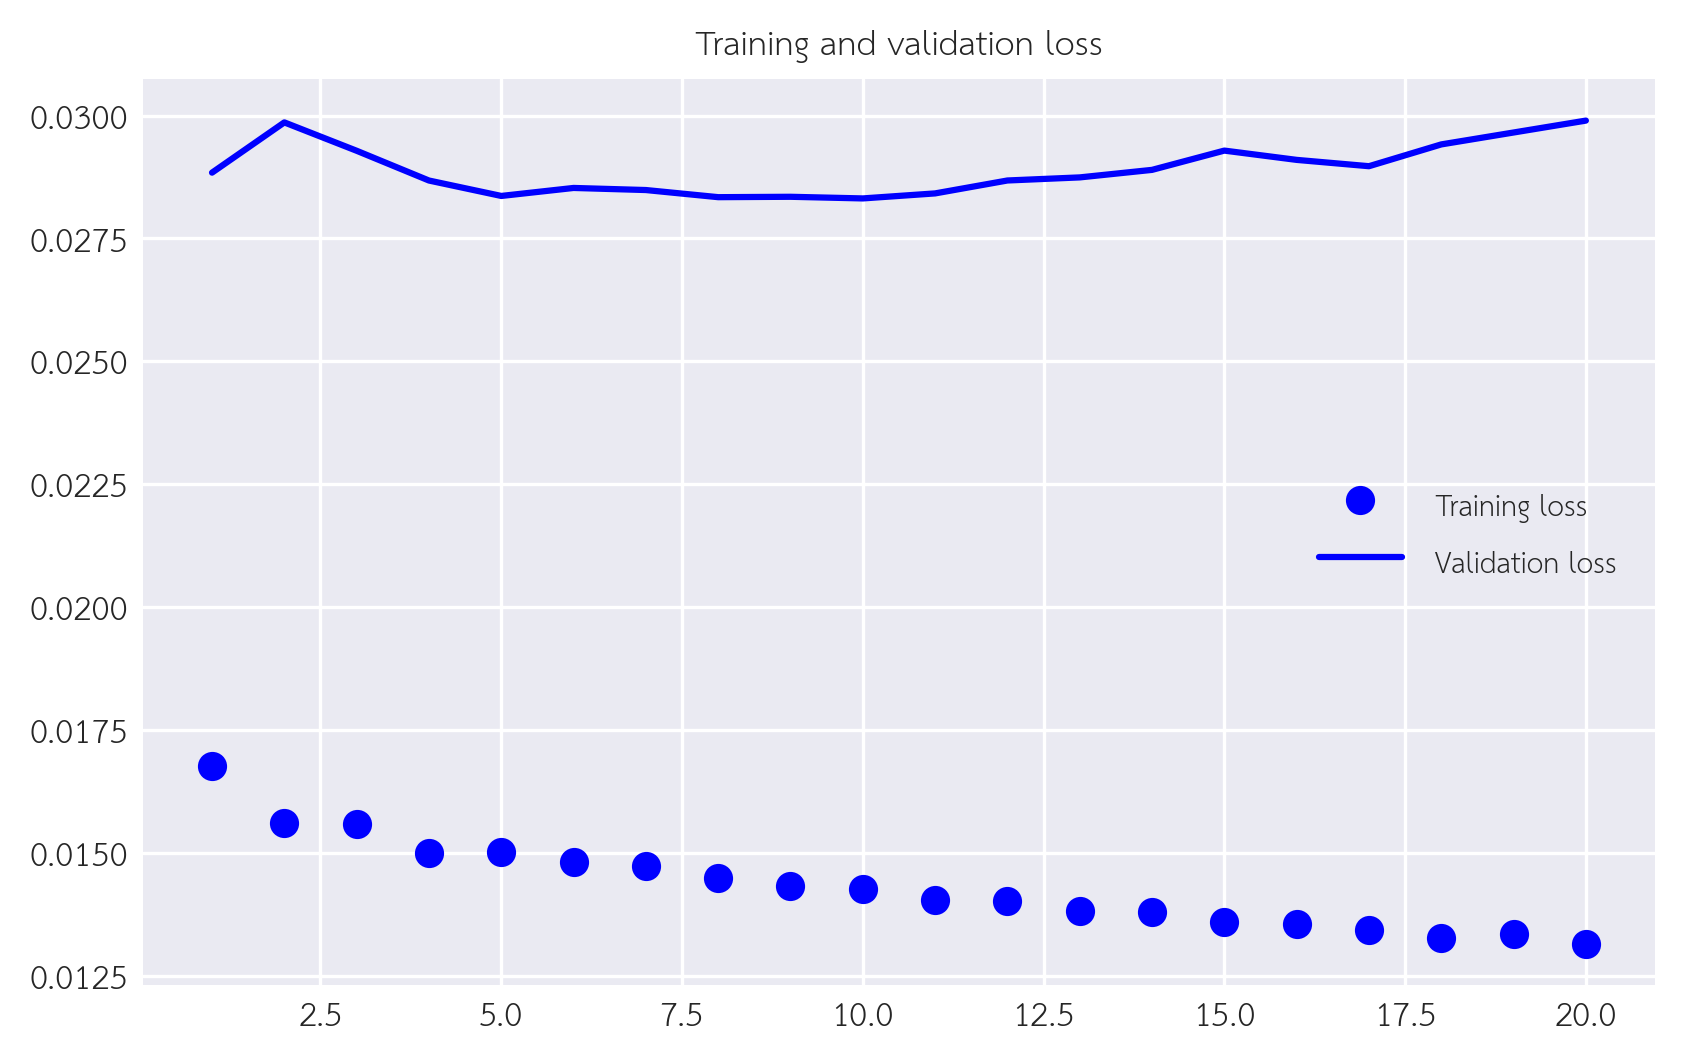

In [16]:
K.clear_session()

n_forecast = 4
n_lag = 6
n_layers = 2
n_nodes = 500
n_epochs = 20
n_batch = 128
refit_rate = np.inf
h = None
data = hml

# transform to keras format
x, y, date_idx = data_2keras(data.train, n_lag=n_lag, n_forecast=n_forecast, h=h)
x_val, y_val, date_idx_val = data_2keras(data.validate, n_lag=n_lag, n_forecast=n_forecast, h=h)
x = x.to_numpy()
y = y.to_numpy()
x_val = x_val.to_numpy()
y_val = y_val.to_numpy()

n_input = x.shape[1]
n_output = n_forecast if h is None else 1

# define model
model = Sequential()
model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
model.add(Dense(n_nodes, activation='relu'))
model.add(Dense(n_output))
model.compile(loss='mae', optimizer='adam')

# # fit model
history = model.fit(x, y,
                    epochs=n_epochs, batch_size=n_batch, 
                    verbose=2,
                    validation_data=(x_val, y_val),
                    shuffle=True
                   )

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [578]:
n_diff = 0

for price in prices:
  price.scaled, price.scaler = data_transform(price, method='minmax')
  price.scaled_diff = price.scaled.diff(n_diff).dropna() if n_diff>0 else price.scaled
  price.n_diff = n_diff
  price.train, price.validate, price.train2, price.test = data_split(price.scaled_diff)
  print(price.meta.abb, price.train.size, price.validate.size, price.test.size)
  
n_input = 24
n_layers = 2
n_nodes = 500
n_epochs = 60
n_batch = 128
refit_rate = np.inf
h = 2

config = (n_input, n_layers, n_nodes, n_epochs, n_batch, refit_rate)
fitted = [mlp_fit(hml.train, config, n_forecast=4, h=1), 
          mlp_fit(hml.train, config, n_forecast=4, h=2), 
         ]
mlp_forecast(fitted[1], hml, '2019-09-01', n_forecast=4, h=h)

hml 259 85 85
wht 259 85 85
glu 259 85 85


2019-11-01   13,497.7266
Name: yhat, dtype: float32

In [576]:
hml.scaled

,y
date,
1984-01-01,0.0452
1984-02-01,0.0438
1984-03-01,0.0421
1984-04-01,0.0492
1984-05-01,0.0506
...,...
2019-05-01,0.8952
2019-06-01,0.8982
2019-07-01,0.8806


## Config Test

In [445]:
n_input = 24
n_layers = 2
n_nodes = 500
n_epochs = 60
n_batch = 128
refit_rate = np.inf
h = 2

config = (n_input, n_layers, n_nodes, n_epochs, n_batch, refit_rate)
fitted = mlp_fit(hml.train, config, n_forecast=4, h=h)
mlp_forecast(fitted, hml, '2018-09-01', n_forecast=4, h=h)

,yhat_scaled,yhat
2018-11-01,0.8722,"15,382.7090"


In [444]:
hml['2018-12']

,y
date,
2018-12-01,"15,244.0000"


## Define functions
- mlp_fit
- mlp_forecast
- mlp_walk_forward

In [299]:
def mlp_walk_forward(data, config, search_mode=False, n_forecast=4):

  train, test = select_traintest(data, search_mode)
  data_ = pd.concat([train,test])
  N = data_.shape[0]
  n_test = test.shape[0]
  n_yhat = n_test+1
  yhat = np.empty((n_yhat, n_forecast))
  refit_rate = config[-1]
  
  history = train
  model_fitted = mlp_fit(history, config, n_forecast=n_forecast)
  date = train.index[-1]
  for i in range(n_yhat):
    model_fitted = mlp_fit(history, config, n_forecast=n_forecast) if i%refit_rate==0 else model_fitted 
    yhat[i] = mlp_forecast(model_fitted, data, date, n_forecast=n_forecast)
    if i < n_yhat-1:
      history = history.append(test.iloc[i])
      date = test.index[i]
      
  yhat = pd.DataFrame(yhat,
                      columns=[f'yhat{h}' for h in range(1, n_forecast+1)],
                      index=data_.index[-n_test-1:])

  return yhat

In [312]:
# K.clear_session()

# n_forecast = 4
# n_lag = 12
# n_month = 11
# n_nodes = 500
# n_batch = 256
# refit_rate = 12
# n_epochs = 50

# # transform to keras format
# data = hml
# x, y, date_idx = data_2keras(data.train, n_lag=n_lag, n_forecast=n_forecast)
# x = x.to_numpy()
# y = y.to_numpy()

# x_val, y_val, date_idx_val = data_2keras(data.validate, n_lag=n_lag, n_forecast=n_forecast)

# # define model
# model = Sequential()
# model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
# model.add(Dense(n_nodes, activation='relu'))
# model.add(Dense(n_forecast))
# model.compile(loss='mae', optimizer='adam')

# # # fit model
# history = model.fit(x, y,
#                     epochs=n_epochs, batch_size=n_batch, 
#                     verbose=2,
#                     validation_data=(x_val, y_val))

# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
# plt.show()

## Generate Parameter Grid

In [598]:
n_input = [6, 12, 24]
n_layers = [1, 2]
n_nodes = [250, 500]
n_epochs = [10]
n_batch = [128]
refit_rate = [np.inf]

mlp_configs = model_configs(n_input, n_layers, n_nodes, n_epochs, n_batch, refit_rate)
mlp_model = [mlp_fit, mlp_forecast, mlp_walk_forward, mlp_configs]
mlp_configs

[(2, 1, 100, 20, 128, inf),
 (2, 1, 250, 20, 128, inf),
 (2, 1, 500, 20, 128, inf),
 (2, 2, 100, 20, 128, inf),
 (2, 2, 250, 20, 128, inf),
 (2, 2, 500, 20, 128, inf),
 (12, 1, 100, 20, 128, inf),
 (12, 1, 250, 20, 128, inf),
 (12, 1, 500, 20, 128, inf),
 (12, 2, 100, 20, 128, inf),
 (12, 2, 250, 20, 128, inf),
 (12, 2, 500, 20, 128, inf),
 (24, 1, 100, 20, 128, inf),
 (24, 1, 250, 20, 128, inf),
 (24, 1, 500, 20, 128, inf),
 (24, 2, 100, 20, 128, inf),
 (24, 2, 250, 20, 128, inf),
 (24, 2, 500, 20, 128, inf)]

In [ ]:
%%time
n_forecast = 4
npr.seed(1305)
for price in prices:
  price.mlp_grid_result, price.mlp_config = grid_search(price, mlp_model, n_forecast=n_forecast)
  price.mlp_yhat = forecast(price, mlp_model, price.mlp_config, n_forecast=n_forecast)

{('2-1-100-20-128-inf',): {'rmse': 3249.6297, 'mae': 2748.7971, 'mape': 0.2106}}
{('2-1-250-20-128-inf',): {'rmse': 2570.0556, 'mae': 2058.9543, 'mape': 0.1588}}
{('2-1-500-20-128-inf',): {'rmse': 2257.1064, 'mae': 1691.0352, 'mape': 0.1286}}
{('2-2-100-20-128-inf',): {'rmse': 1909.1398, 'mae': 1323.0025, 'mape': 0.1002}}
{('2-2-250-20-128-inf',): {'rmse': 1791.5359, 'mae': 1193.4756, 'mape': 0.0914}}
{('2-2-500-20-128-inf',): {'rmse': 1667.639, 'mae': 1051.9333, 'mape': 0.0801}}
{('12-1-100-20-128-inf',): {'rmse': 2513.4821, 'mae': 1898.1666, 'mape': 0.1465}}
{('12-1-250-20-128-inf',): {'rmse': 2354.3243, 'mae': 1724.6379, 'mape': 0.1322}}
{('12-1-500-20-128-inf',): {'rmse': 2018.6186, 'mae': 1355.1841, 'mape': 0.1032}}
{('12-2-100-20-128-inf',): {'rmse': 1863.0865, 'mae': 1226.6651, 'mape': 0.0931}}
{('12-2-250-20-128-inf',): {'rmse': 1878.7589, 'mae': 1237.4558, 'mape': 0.0942}}
{('12-2-500-20-128-inf',): {'rmse': 1885.9515, 'mae': 1273.5462, 'mape': 0.0973}}
{('24-1-100-20-128-inf'

In [595]:
for price in prices:
  print(price.mlp_config)

(24, 2, 500, 10, 128, inf)
(24, 2, 500, 10, 128, inf)
(12, 2, 500, 10, 128, inf)


In [239]:
hml.mlp_yhat

,yhat1,yhat2,yhat3,yhat4
date,,,,
2012-08-01,"15,688.2287","15,949.0151","16,121.4170","16,068.9368"
2012-09-01,"15,835.8381","16,006.2435","15,965.3571","15,802.1307"
2012-10-01,"16,031.1525","16,089.2506","16,021.2716","15,815.9985"
2012-11-01,"15,118.8547","15,057.9924","15,011.2360","15,031.8277"
2012-12-01,"15,448.4310","15,485.7017","15,414.0533","15,467.3528"
...,...,...,...,...
2019-05-01,"15,873.8633","15,841.8249","15,616.0188","15,544.6092"
2019-06-01,"15,773.0569","15,680.3780","15,611.9302","15,600.9963"
2019-07-01,"15,353.8756","15,368.1603","15,482.6903","15,658.9755"


In [596]:
model_measure(hml, hml.mlp_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,"1,670.8124","1,311.9203",0.1035,"1,441.4547","1,089.1330",0.0844,"1,560.3049","1,248.9084",0.1024,"1,781.4808","1,406.3546",0.1103,"1,900.0091","1,503.2852",0.1170


In [49]:
model_measure(hml, hml.mlp_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,941.3093,669.6921,0.0541,569.1436,409.0225,0.0331,820.2800,576.2235,0.0464,"1,068.9386",741.9913,0.0600,"1,306.8751",951.5312,0.0769


In [256]:
model_measure(wht, wht.mlp_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,473.5901,360.1268,0.0448,275.6254,203.4851,0.0248,434.6486,351.0368,0.0434,552.2428,421.7821,0.0525,631.8436,464.2031,0.0583


In [50]:
model_measure(wht, wht.mlp_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,483.4285,371.9784,0.0467,337.6808,267.6040,0.0333,481.3125,377.3354,0.0475,532.5556,408.9011,0.0514,582.1650,434.0731,0.0547


In [257]:
model_measure(glu, glu.mlp_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,878.9446,669.0682,0.0612,523.7281,387.9629,0.0355,798.9364,597.5100,0.0548,"1,002.4343",787.3643,0.0723,"1,190.6796",903.4357,0.0821


In [51]:
model_measure(glu, glu.mlp_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,854.9932,655.1897,0.0594,553.8348,413.3423,0.0375,809.7939,605.1687,0.0555,950.5414,743.4416,0.0673,"1,105.8028",858.8059,0.0773


In [187]:
for i in prices:
    config = "-".join((str(j) for j in i.mlp_config))
    print(config, '\n', i.mlp_grid_result.loc[config])

11-1-500-10-256-12 
                          rmse      mae   mape    rmse1     mae1  mape1  \
11-1-500-10-256-12 1,194.1645 729.5656 0.0557 669.0943 383.3198 0.0301   

                        rmse2     mae2  mape2      rmse3     mae3  mape3  \
11-1-500-10-256-12 1,073.4292 647.5995 0.0497 1,407.5221 877.9882 0.0668   

                        rmse4       mae4  mape4  
11-1-500-10-256-12 1,626.6123 1,009.3548 0.0762  
15-2-100-10-256-12 
                          rmse      mae   mape    rmse1     mae1  mape1  \
15-2-100-10-256-12 1,025.4758 593.9517 0.0623 606.3654 358.1584 0.0380   

                      rmse2     mae2  mape2      rmse3     mae3  mape3  \
15-2-100-10-256-12 948.3270 553.8491 0.0588 1,183.1963 669.0560 0.0705   

                        rmse4     mae4  mape4  
15-2-100-10-256-12 1,364.0146 794.7433 0.0819  
15-1-500-10-256-12 
                          rmse      mae   mape    rmse1     mae1  mape1  \
15-1-500-10-256-12 1,283.5246 981.5932 0.0960 681.3290 496.9952 0.0

In [16]:
path = '../results/result_mlp_4.pkl'
result = dict()

if(os.path.isfile(path)):
    result = joblib.load(path)
else:
    for price in prices:
        result[price.meta.abb] = [price.mlp_grid_result, price.mlp_config, price.mlp_yhat]
    joblib.dump(result, path)

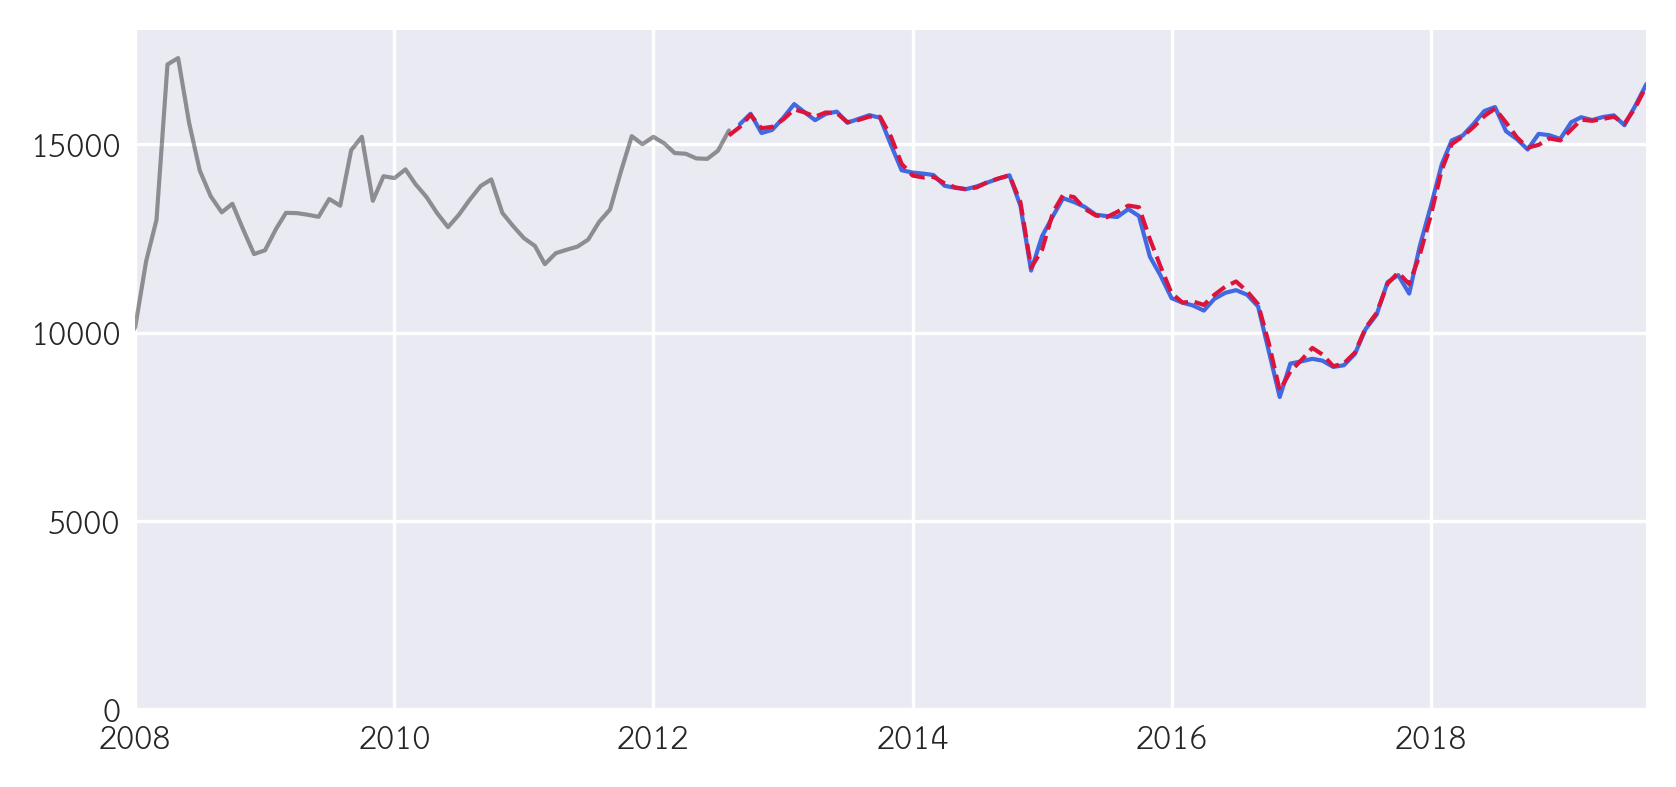

In [38]:
plot_fcast(hml, 'mlp', step=1)

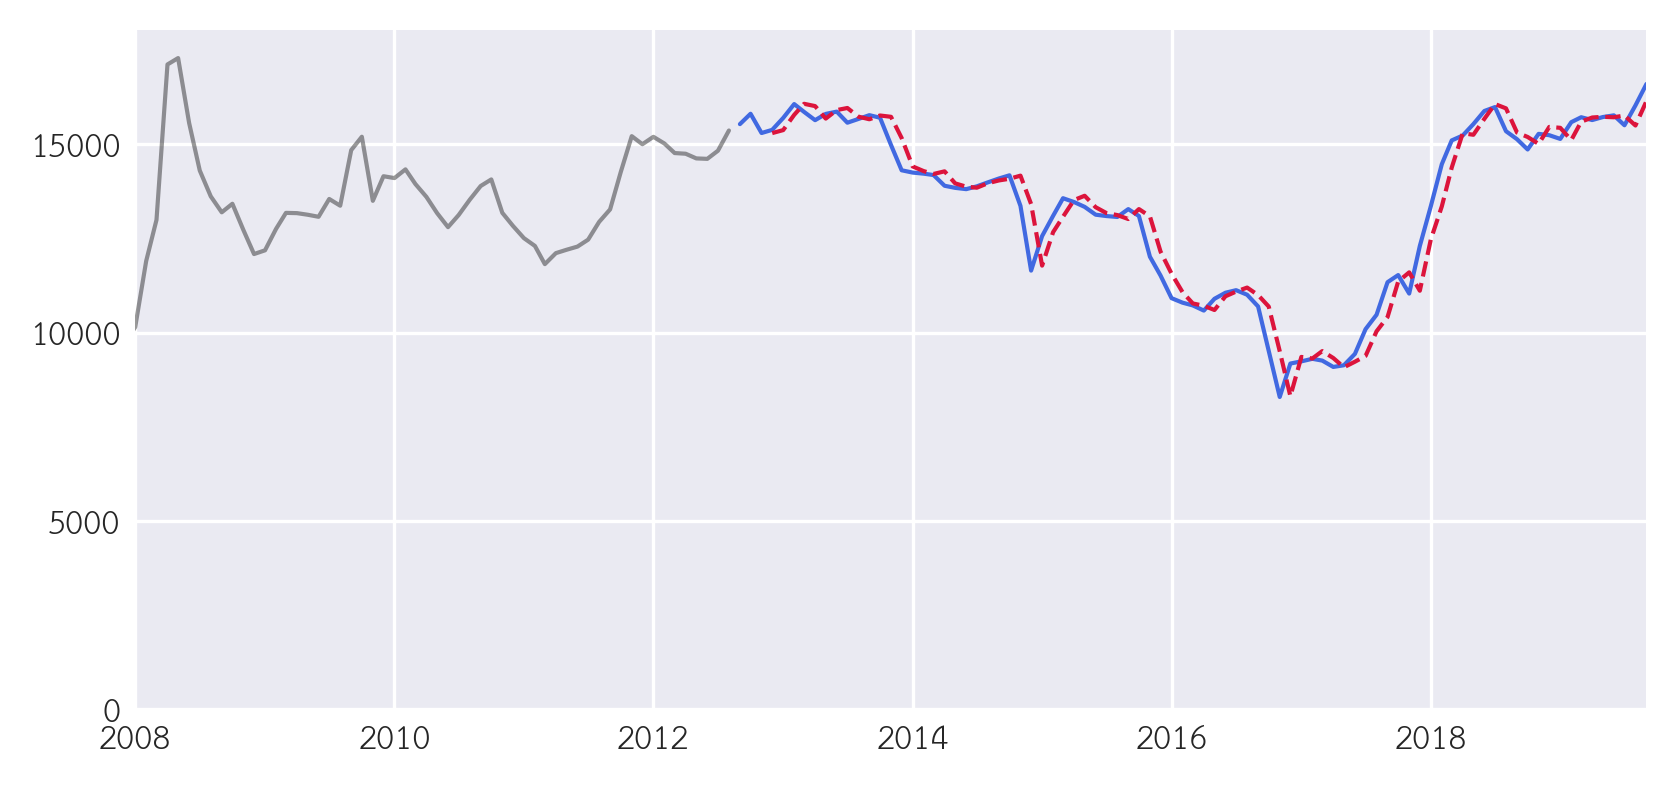

In [18]:
plot_fcast(hml, 'mlp', step=4)

In [15]:
model_measure(hml, hml.mlp_yhat, ['hml'])

,rmse,mae,mape
config,,,
hml,503.4071,348.8937,0.0284


In [14]:
model_measure(wht, wht.mlp_yhat, ['wht'])

,rmse,mae,mape
config,,,
wht,285.1482,217.2903,0.0270


In [13]:
model_measure(glu, glu.mlp_yhat, ['glu'])

,rmse,mae,mape
config,,,
glu,521.5118,374.8086,0.0343


In [ ]:
def mlp_fit(data, config, n_forecast=4, search_mode=False):
    
    # unpack config
    n_lag, n_layers, n_nodes, n_epochs, n_batch, refit_rate = config
    
    train, test = select_traintest(data, search_mode)
    
    # transform to kreas format
    x, y, date_idx = data_2keras(train, n_lag=n_lag, n_forecast=n_forecast)
    x = x.to_numpy()
    y = y.to_numpy()
    
    x_val, y_val, _ = data_2keras(test, n_lag=n_lag, n_forecast=n_forecast)
    x_val = x_val.to_numpy()
    y_val = y_val.to_numpy()
    
    # define model
    if n_layers!=1:
        model = Sequential()
        model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
        model.add(Dense(n_nodes, activation='relu'))
        model.add(Dense(n_forecast))
        model.compile(loss='mse', optimizer='adam', metrics=['mae'])
        
    else:
        model = Sequential()
        model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
        model.add(Dense(n_forecast))
        model.compile(loss='mse', optimizer='adam', metrics=['mae'])
        
    # fit model
    model.fit(x, y, epochs=n_epochs, batch_size=n_batch, verbose=0, validation_data=(x_val, y_val))
    return model

In [132]:
# mlp_configs[3]
config = (6, 1, 10, 200, 128, np.inf)
config

(6, 1, 10, 200, 128, inf)

In [133]:
npr.seed(1305)
history = mlp_fit(wht, config, search_mode=True)
res = history.history.history

In [122]:
val_mae = {}
val_mae[str(config)] = res['val_mae']

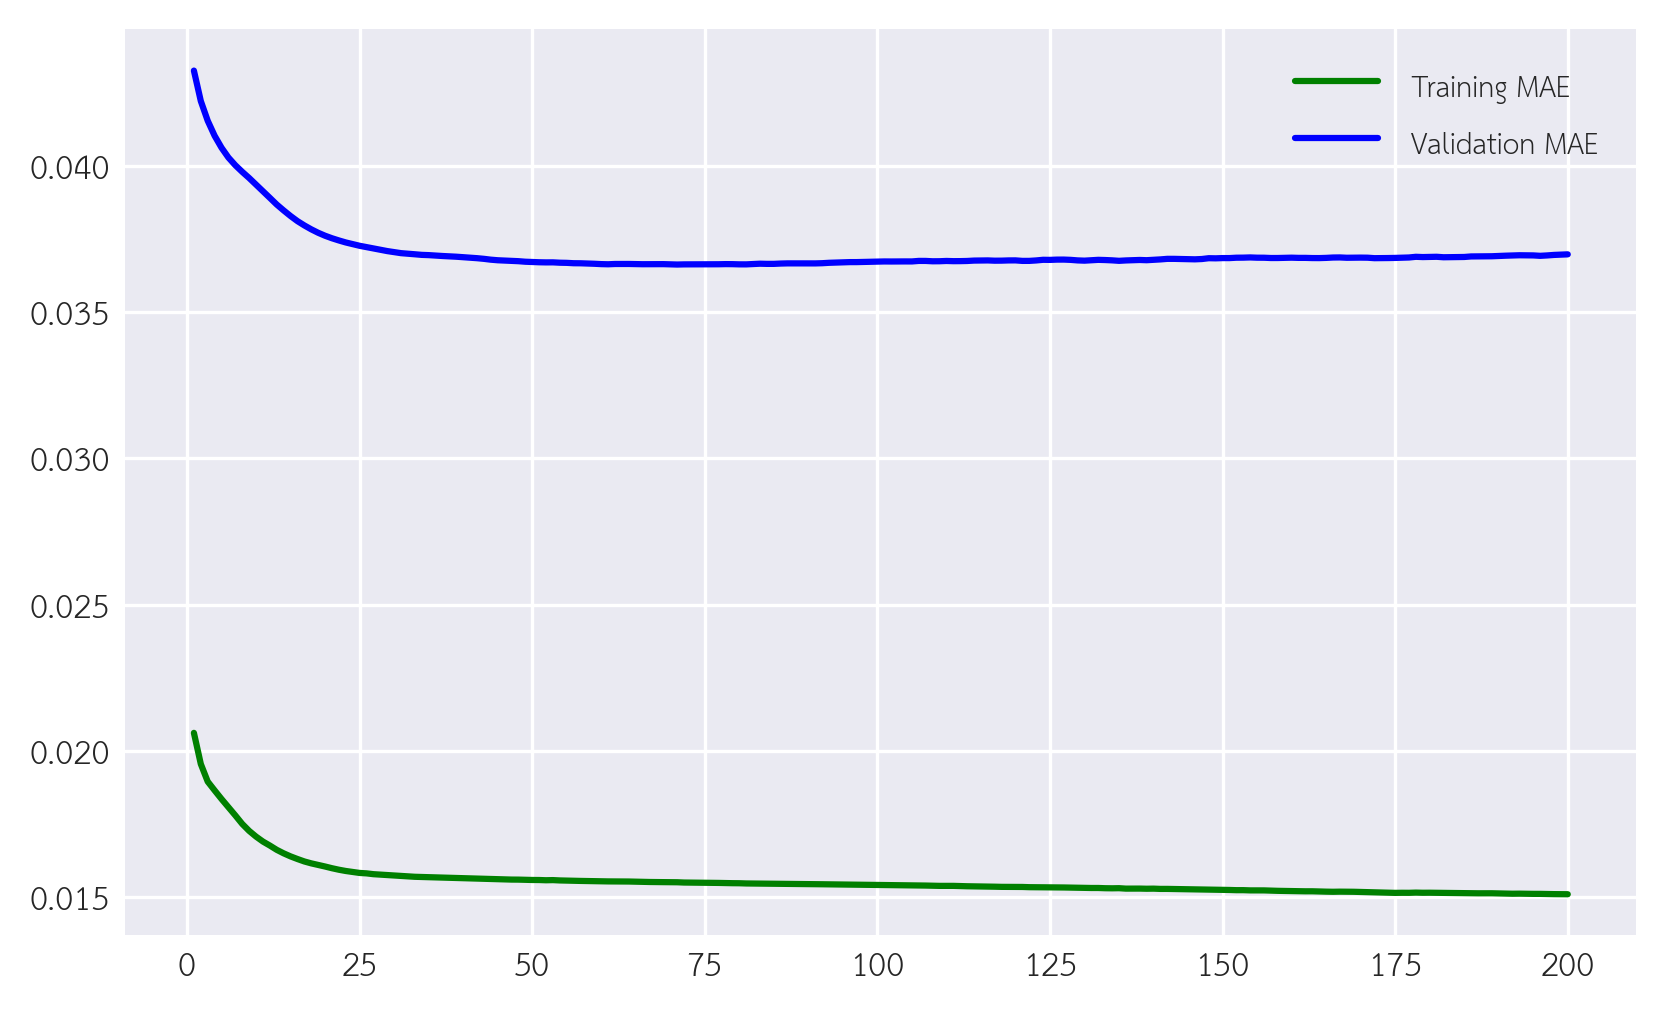

In [134]:
epochs = range(1, len(res['mae'])+1)

plt.plot(epochs, res['mae'], 'g', label='Training MAE')
plt.plot(epochs, res['val_mae'], 'b', label='Validation MAE')
plt.legend()

In [ ]:
def mlp_fit(data, config, n_forecast=4):

  # unpack config
  n_lag, n_layers, n_nodes, n_epochs, n_batch, refit_rate = config
  
  # transform to keras format
  data = data
  x, y, date_idx = data_2keras(data, n_lag=n_lag, n_forecast=n_forecast)
  x = x.to_numpy()
  y = y.to_numpy()

  # define model
  if n_layers==3:
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(n_forecast))
    model.compile(loss='mse', optimizer='adam')
  
  elif n_layers==2:
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(n_forecast))
    model.compile(loss='mse', optimizer='adam')
    
  else:
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
    model.add(Dense(n_forecast))
    model.compile(loss='mse', optimizer='adam')

  # fit model
  model.fit(x, y, epochs=n_epochs, batch_size=n_batch, verbose=0)

  return model


def mlp_forecast(model_fitted, data, date, n_forecast=4):
  """
  Forecast MLP model

  Args:
      model_fitted (model): Keras fitted model
      data (dataframe): number of lags to be used in the model
      date (date): date when making the forecast
      n_forecast (int): number of steps to forecast

  Returns:

  """
  n_diff = getattr(data, "n_diff")
  scaler = getattr(data, "scaler")
  x_idx = data.scaled.index.get_loc(date)+1
  n_input = model_fitted.input_shape[1]

  # find-input
  x = data.scaled.iloc[x_idx-n_input:x_idx,]
  x_input = x.to_numpy().reshape(1,-1)

  # forecast
  yhat = model_fitted.predict(x_input, verbose=0).reshape(-1,)
  K.clear_session()
  df = pd.DataFrame(yhat,
                    columns=["yhat_scaled"],
                    index=pd.date_range(date, periods=n_forecast+1, freq='MS')[1:]
                   )
  df['yhat'] = scaler.inverse_transform(df)
  
  return df['yhat']